In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
directory = '../data/'
output_dir = '../data/csv_grouped_data'

In [5]:
filename_ibex ="../data/grouped_data_day_mean_tweets_sentimentdata-scraper_ibex_2018-2020.csv"
filename_ibex_prices ="../data/ibex_historico.csv"
filename_precios_bolsa = "../data/es_mse_mean_day.csv"
filename_asoc = "../data/grouped_data_day_mean_tweets_sentimentdata-scraper_asociaciones_2016-2020.csv"

filename_ibex_prices_complete ="../data/bolsas_ibex_2010-2021.csv"
filename_precios_bolsa_complete = "../data/bolsa_mad_2010-2021.csv"


df_asoc = pd.read_csv(filename_asoc, sep=";")
df_ibex = pd.read_csv(filename_ibex, sep=";")

df_ibex_prices_complete = pd.read_csv(filename_ibex_prices_complete, sep=";")
df_precios_bolsa_complete = pd.read_csv(filename_precios_bolsa_complete, sep=";")

df_asoc['normalised_date'] = pd.to_datetime(df_asoc['normalised_date'], errors='coerce')
df_asoc['normalised_date'] = df_asoc['normalised_date'].dt.normalize()
df_ibex['normalised_date'] = pd.to_datetime(df_ibex['normalised_date'], errors='coerce')
df_ibex['normalised_date'] = df_ibex['normalised_date'].dt.normalize()


df_ibex_prices_complete = df_ibex_prices_complete.rename(columns={"Dates": "Date", "LAST_PRICE": "Close"})
df_precios_bolsa_complete = df_precios_bolsa_complete.rename(columns={"Dates": "Date", "LAST_PRICE": "Close"})

df_ibex_prices_complete['Date'] = pd.to_datetime(df_ibex_prices_complete['Date'], errors='coerce')
df_ibex_prices_complete['Date'] = df_ibex_prices_complete['Date'].dt.normalize()

df_precios_bolsa_complete['Date'] = pd.to_datetime(df_precios_bolsa_complete['Date'], errors='coerce')
df_precios_bolsa_complete['Date'] = df_precios_bolsa_complete['Date'].dt.normalize()
df_precios_bolsa_complete

,Date,PX_LAST,Close,PX_VOLUME
0,2010-01-04,1262.36,1262.36,384913800
1,2010-01-05,1270.38,1270.38,505626074
2,2010-01-06,1272.66,1272.66,244844486
3,2010-01-07,1266.79,1266.79,367925910
4,2010-01-08,1267.17,1267.17,406368652
...,...,...,...,...
2886,2021-01-26,795.18,795.18,303963416
2887,2021-01-27,783.35,783.35,356659296
2888,2021-01-28,790.87,790.87,341922663
2889,2021-01-29,773.46,773.46,397867464


In [6]:
df_x = pd.merge(left=df_asoc, right=df_ibex, left_on='normalised_date', right_on='normalised_date')
df_total = pd.merge(left=df_x, right=df_precios_bolsa_complete, left_on='normalised_date', right_on='Date')
df_total = df_total.rename(columns={"sentiment_x": "sentiment_asociacones", "sentiment_y": "sentiment_ibex"})
df_total["normalised_date"]= pd.to_datetime(df_total["normalised_date"]) 
df_total = df_total[["normalised_date","sentiment_asociacones", "sentiment_ibex", "Close"]]
df_total

,normalised_date,sentiment_asociacones,sentiment_ibex,Close
0,2017-01-23,0.382451,0.464199,939.12
1,2017-01-24,0.414193,0.463779,948.31
2,2017-01-25,0.406419,0.031743,965.33
3,2017-01-26,0.367457,0.511189,962.08
4,2017-01-27,0.414319,0.093482,961.09
...,...,...,...,...
862,2020-05-13,0.323553,0.198299,654.81
863,2020-05-14,0.283648,0.211395,646.78
864,2020-05-15,0.332006,0.247824,639.86
865,2020-05-18,0.303138,0.228137,669.19


In [7]:
df_total.sentiment_asociacones = df_total.sentiment_asociacones
df_total.sentiment_ibex = df_total.sentiment_ibex
df_total.Close = df_total.Close.diff()
df_total = df_total.rename(columns={"Close": "madrid_change"})

df_total['sentiment_asociacones'] = df_total['sentiment_asociacones'].astype(float).diff()
df_total['sentiment_ibex'] = df_total['sentiment_ibex'].astype(float).diff()
df_total['madrid_change'] = df_total['madrid_change'].astype(float)

df_total = df_total.dropna()
df_total = df_total[['normalised_date','sentiment_asociacones', 'sentiment_ibex', 'madrid_change']]
df_total.to_csv("df_total_es.csv", sep=";")

df_total_no_covid = df_total.copy()
df_total_no_covid = df_total_no_covid[:-300]
df_total_no_covid



,normalised_date,sentiment_asociacones,sentiment_ibex,madrid_change
1,2017-01-24,0.031742,-0.000420,9.19
2,2017-01-25,-0.007774,-0.432036,17.02
3,2017-01-26,-0.038962,0.479446,-3.25
4,2017-01-27,0.046862,-0.417707,-0.99
5,2017-01-30,-0.008826,0.478613,-14.20
...,...,...,...,...
562,2019-03-20,0.002392,-0.003552,-8.14
563,2019-03-21,-0.001417,0.022644,-5.59
564,2019-03-22,0.012694,0.013926,-16.33
565,2019-03-25,0.077746,-0.046812,-2.18


In [8]:
from statsmodels.tsa.stattools import grangercausalitytests

start_date = "2020-01-10 00:00:00.000"
end_date = "2020-05-01 00:00:00.000"

mask = (df_total['normalised_date'] > start_date) & (df_total['normalised_date'] <= end_date)
df_restricted = df_total.copy()
df_restricted = df_restricted.loc[mask]
print(df_restricted)


granger_test = sm.tsa.stattools.grangercausalitytests(df_restricted[['sentiment_ibex','madrid_change']], maxlag=8, verbose=True)

#ALL LAGS SIGNIFICATIVE

    normalised_date  sentiment_asociacones  sentiment_ibex  madrid_change
775      2020-01-13               0.039317       -0.071115          -3.15
776      2020-01-14              -0.026994       -0.028977          -2.24
777      2020-01-15               0.092732        0.029453          -1.68
778      2020-01-16              -0.046320        0.071231           5.95
779      2020-01-17              -0.050825       -0.063411          10.07
..              ...                    ...             ...            ...
850      2020-04-27              -0.015568       -0.008943          12.02
851      2020-04-28              -0.085925       -0.008434          11.52
852      2020-04-29               0.031606        0.003427          22.03
853      2020-04-30               0.007409        0.032325         -13.13
854      2020-05-01               0.180732        0.071654           0.00

[80 rows x 4 columns]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5894  , p=0.0

In [9]:
from statsmodels.tsa.stattools import grangercausalitytests

start_date = "2020-01-10 00:00:00.000"
end_date = "2020-05-01 00:00:00.000"

mask = (df_total['normalised_date'] > start_date) & (df_total['normalised_date'] <= end_date)
df_restricted = df_total.copy()
df_restricted = df_restricted.loc[mask]
print(df_restricted)


granger_test = sm.tsa.stattools.grangercausalitytests(df_restricted[['sentiment_asociacones','madrid_change']], maxlag=11, verbose=True)
granger_test

#lasgs 9 10 and 11 signif

    normalised_date  sentiment_asociacones  sentiment_ibex  madrid_change
775      2020-01-13               0.039317       -0.071115          -3.15
776      2020-01-14              -0.026994       -0.028977          -2.24
777      2020-01-15               0.092732        0.029453          -1.68
778      2020-01-16              -0.046320        0.071231           5.95
779      2020-01-17              -0.050825       -0.063411          10.07
..              ...                    ...             ...            ...
850      2020-04-27              -0.015568       -0.008943          12.02
851      2020-04-28              -0.085925       -0.008434          11.52
852      2020-04-29               0.031606        0.003427          22.03
853      2020-04-30               0.007409        0.032325         -13.13
854      2020-05-01               0.180732        0.071654           0.00

[80 rows x 4 columns]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7482  , p=0.3

{1: ({'ssr_ftest': (0.7482179635615743, 0.38976318999592086, 76.0, 1),
   'ssr_chi2test': (0.777752883175847, 0.3778292702073457, 1),
   'lrtest': (0.7739493484529021, 0.378998055902965, 1),
   'params_ftest': (0.7482179635615694, 0.38976318999592086, 76.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.18163770351380398, 0.8342791264587786, 73.0, 2),
   'ssr_chi2test': (0.38815728422127976, 0.823593132619463, 2),
   'lrtest': (0.38719466827154747, 0.8239896299732525, 2),
   'params_ftest': (0.18163770351372727, 0.8342791264588432, 73.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.49652922381742126, 0.6858737198686371, 70.0, 3),
   'ssr_chi2test': (1.6385464385974902, 0.6506815968517405, 3),
   'lrtest': (1.6213558956417842, 0.6545572664906014, 3),
   'params_ftest': (0.49652922381756875, 0.6858737198685354, 70.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0

In [10]:

start_date = "2020-01-01 00:00:00.000"
end_date = "2020-06-01 00:00:00.000"

mask = (df_total['normalised_date'] > start_date) & (df_total['normalised_date'] <= end_date)
df_restricted = df_total.copy()
df_restricted = df_restricted.loc[mask]

from statsmodels.tsa.stattools import grangercausalitytests
granger_test = sm.tsa.stattools.grangercausalitytests(df_restricted[['sentiment_ibex','madrid_change']], maxlag=11, verbose=True)
print(granger_test)

#ALL LAGS SIGNIFICATIVE



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0451  , p=0.0471  , df_denom=95, df_num=1
ssr based chi2 test:   chi2=4.1729  , p=0.0411  , df=1
likelihood ratio test: chi2=4.0865  , p=0.0432  , df=1
parameter F test:         F=4.0451  , p=0.0471  , df_denom=95, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4149  , p=0.0371  , df_denom=92, df_num=2
ssr based chi2 test:   chi2=7.2011  , p=0.0273  , df=2
likelihood ratio test: chi2=6.9463  , p=0.0310  , df=2
parameter F test:         F=3.4149  , p=0.0371  , df_denom=92, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4615  , p=0.0678  , df_denom=89, df_num=3
ssr based chi2 test:   chi2=7.9654  , p=0.0467  , df=3
likelihood ratio test: chi2=7.6522  , p=0.0538  , df=3
parameter F test:         F=2.4615  , p=0.0678  , df_denom=89, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6444  , p=0.0389  , df_d

In [11]:
from statsmodels.tsa.stattools import grangercausalitytests
granger_test = sm.tsa.stattools.grangercausalitytests(df_total_no_covid[['sentiment_ibex','madrid_change']], maxlag=1, verbose=True)
print(granger_test)

from statsmodels.tsa.stattools import grangercausalitytests
granger_test = sm.tsa.stattools.grangercausalitytests(df_total_no_covid[['sentiment_asociacones','madrid_change']], maxlag=1, verbose=True)
print(granger_test)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5518  , p=0.2134  , df_denom=562, df_num=1
ssr based chi2 test:   chi2=1.5601  , p=0.2116  , df=1
likelihood ratio test: chi2=1.5580  , p=0.2120  , df=1
parameter F test:         F=1.5518  , p=0.2134  , df_denom=562, df_num=1
{1: ({'ssr_ftest': (1.5518323276746808, 0.21338422438088517, 562.0, 1), 'ssr_chi2test': (1.5601161301355775, 0.21164821739613293, 1), 'lrtest': (1.55796613805569, 0.2119632653995812, 1), 'params_ftest': (1.5518323276746562, 0.21338422438088517, 562.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x15b4c43a0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x15be148e0>, array([[0., 1., 0.]])])}

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2949  , p=0.5873  , df_denom=562, df_num=1
ssr based chi2 test:   chi2=0.2965  , p=0.5861  , df=1
likelihood ratio test: chi2=0.2964  , p=0.5862  , df=1
parameter F 

In [12]:
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
# Fit the model
model = VAR(df_total_no_covid[['sentiment_asociacones', 'sentiment_ibex', 'madrid_change']])
results = model.fit(maxlags=15, ic='aic')

# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
# Fit the model
model_restricted = VAR(df_restricted[['sentiment_asociacones', 'sentiment_ibex', 'madrid_change']])
results_restricted = model.fit(maxlags=15, ic='aic')
results.summary()

/Users/hugojose/.local/share/virtualenvs/twitter-data-scripts-analysis-uDKChz6k/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/hugojose/.local/share/virtualenvs/twitter-data-scripts-analysis-uDKChz6k/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Feb, 2021
Time:                     20:20:09
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -6.71922
Nobs:                     553.000    HQIC:                  -7.28979
Log likelihood:          -117.234    FPE:                0.000473726
AIC:                     -7.65564    Det(Omega_mle):     0.000384183
--------------------------------------------------------------------
Results for equation sentiment_asociacones
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            -0.000044         0.002031           -0.021           0.983
L1.sentiment_asociacones         -0.781381         0.043811          -17.835           0.

In [13]:
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
# Fit the model
model_no_covid = VAR(df_total_no_covid[['sentiment_asociacones', 'sentiment_ibex', 'madrid_change']])
results_no_covid = model_no_covid.fit(maxlags=15, ic='aic')
results_no_covid.summary()

/Users/hugojose/.local/share/virtualenvs/twitter-data-scripts-analysis-uDKChz6k/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Feb, 2021
Time:                     20:20:24
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -6.71922
Nobs:                     553.000    HQIC:                  -7.28979
Log likelihood:          -117.234    FPE:                0.000473726
AIC:                     -7.65564    Det(Omega_mle):     0.000384183
--------------------------------------------------------------------
Results for equation sentiment_asociacones
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            -0.000044         0.002031           -0.021           0.983
L1.sentiment_asociacones         -0.781381         0.043811          -17.835           0.

In [14]:

# convert to (records, timesteps, indicators)
def create_window_data_arrays(arrays,window_size):
    data = np.column_stack((arrays))
    arr_len = len(arrays[0])
    windows = np.array([data[i-window_size: i] for i in range(window_size +1,arr_len+1)])
    return windows


def create_window_data_array_with_shift(array,window_size, shift):
    return np.array([array[i-window_size: i] for i in range(shift +1,len(array)+1)])

In [15]:
lag_order = results.k_ar
print(df_total_no_covid)
train_x = create_window_data_arrays((df_total_no_covid.sentiment_asociacones,df_total_no_covid.sentiment_ibex, df_total_no_covid.madrid_change), lag_order)
print(train_x.shape)
print(train_x[-1])
print("----")

print(df_total_no_covid.values[-1])
print("----")
print(results.forecast(train_x[-1], 1))


    normalised_date  sentiment_asociacones  sentiment_ibex  madrid_change
1        2017-01-24               0.031742       -0.000420           9.19
2        2017-01-25              -0.007774       -0.432036          17.02
3        2017-01-26              -0.038962        0.479446          -3.25
4        2017-01-27               0.046862       -0.417707          -0.99
5        2017-01-30              -0.008826        0.478613         -14.20
..              ...                    ...             ...            ...
562      2019-03-20               0.002392       -0.003552          -8.14
563      2019-03-21              -0.001417        0.022644          -5.59
564      2019-03-22               0.012694        0.013926         -16.33
565      2019-03-25               0.077746       -0.046812          -2.18
566      2019-03-26              -0.051777        0.046949          -0.13

[566 rows x 4 columns]
(553, 13, 3)
[[ 1.26508692e-02  2.87928083e-02 -1.19700000e+01]
 [ 1.27698532e-01  8.062

In [16]:
lag_order_restricted = results_restricted.k_ar
train_x_restricted = create_window_data_arrays((df_restricted.sentiment_asociacones,df_restricted.sentiment_ibex, df_restricted.madrid_change), lag_order_restricted)


In [17]:
results.forecast(train_x[0], 1)
forecasted = np.array([list(results.forecast(train_x[i], 1)[0]) for i in range(0,train_x.shape[0])])
print(forecasted[-1])

print(df_total.values.shape)
print(forecasted.shape)

# while using one ts
#y_pred = forecasted[:,1:]
y_pred = forecasted[:,2:]
y_train = df_total_no_covid.madrid_change.values[lag_order:]

M = np.column_stack((y_train, y_pred))

from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(forecasted, y_pred))


print(M)
plt.plot(M[-200:])

[-0.02708576 -0.0107863  -2.10116608]
(866, 4)
(553, 3)


ValueError: y_true and y_pred have different number of output (3!=1)

15.569313486516325
[[-4.30000000e+00  2.63657026e+00]
 [-3.69000000e+00 -5.28676388e+00]
 [-5.23000000e+00  5.17093618e-01]
 [ 3.71000000e+00  2.38157693e+00]
 [-1.89600000e+01  6.27842901e+00]
 [ 1.14900000e+01  2.23477946e+00]
 [ 7.00000000e+00  6.35073011e-01]
 [-6.73000000e+00 -5.46949535e+00]
 [-1.14300000e+01  6.44232695e-01]
 [ 2.58000000e+00  1.11070904e-02]
 [ 1.57900000e+01  1.33817254e+00]
 [ 1.51200000e+01 -2.17928488e-01]
 [ 9.16000000e+00 -4.38088357e+00]
 [ 9.00000000e-02  3.39692500e+00]
 [ 4.60000000e-01 -1.39453272e+00]
 [ 6.88000000e+00 -6.44991459e-01]
 [ 6.81000000e+00  4.01887952e-01]
 [-2.83000000e+00  1.91176067e+00]
 [ 4.17000000e+00 -3.06805441e+00]
 [ 6.57000000e+00 -4.38393978e+00]
 [-2.02000000e+00 -1.20771329e+00]
 [ 6.38000000e+00 -8.10868120e-01]
 [-1.42100000e+01  1.11498859e+00]
 [-5.16000000e+00  9.20566919e-02]
 [-3.85500000e+01 -7.06520177e-01]
 [-2.33400000e+01 -1.80282400e+00]
 [ 7.01000000e+00  3.38080159e-01]
 [-3.18900000e+01  1.54253086e+00]
 

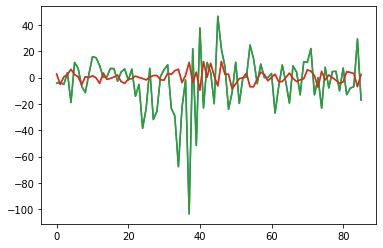

In [18]:
results_restricted.forecast(train_x[0], 1)
forecasted = np.array([list(results_restricted.forecast(train_x_restricted[i], 1)[0]) for i in range(0,train_x_restricted.shape[0])])

y_pred = forecasted[:,2:]
y_train = df_restricted.madrid_change.values[lag_order_restricted:]

M = np.column_stack((y_train, y_pred))

from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_train, y_pred))


print(M)
plt.plot(M[-200:])
print(M)
plt.plot(M[-200:])

In [19]:
# Split data
nobs = 4
df_train, df_test = df_total[0:-nobs], df_total[-nobs:]
# Check for stationarity with Augmented Dickey-Fuller Test (ADF Test)
# Augmented Dickey-Fuller Test (ADF Test)/unit root test
from statsmodels.tsa.stattools import adfuller

def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")

#apply adf test on the series
adf_test(df_train["sentiment_asociacones"])
adf_test(df_train["sentiment_ibex"])
adf_test(df_train["madrid_change"])

Test Statistic         -1.138006e+01
p-value                 8.554846e-21
# Lags                  2.100000e+01
# Observations          8.400000e+02
Critical Value (1%)    -3.438159e+00
Critical Value (5%)    -2.864987e+00
Critical Value (10%)   -2.568605e+00
dtype: float64
 Series is Stationary
Test Statistic         -1.024985e+01
p-value                 4.515531e-18
# Lags                  1.600000e+01
# Observations          8.450000e+02
Critical Value (1%)    -3.438112e+00
Critical Value (5%)    -2.864966e+00
Critical Value (10%)   -2.568595e+00
dtype: float64
 Series is Stationary
Test Statistic         -7.183908e+00
p-value                 2.606721e-10
# Lags                  2.100000e+01
# Observations          8.400000e+02
Critical Value (1%)    -3.438159e+00
Critical Value (5%)    -2.864987e+00
Critical Value (10%)   -2.568605e+00
dtype: float64
 Series is Stationary
